# 0. Introduction to the Dataset

The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

## 0.1 Environment Set-up and Dataset Download

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c home-credit-default-risk

In [13]:
import glob

zips = glob.glob('/content/*.zip')

In [14]:
!mkdir datasets

In [15]:
from zipfile import ZipFile

for i in zips:
  zf = ZipFile(i, 'r')
  zf.extractall('/content/datasets/')
  zf.close()

In [16]:
import os

for i in zips:
  os.remove(i)

# 1. Necessary Imports

In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

In [2]:
# To stop warning from showing
import warnings
warnings.filterwarnings('ignore')

# 2. Feature Engineering

In [3]:
# Function to handle missing values in a column

def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [4]:
# Function to plot the required data

def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
    cat_perc = train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

In [5]:

def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = train.loc[train['TARGET'] != 0]
    t0 = train.loc[train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

# 2.1 Load Dataset

In [6]:
train = pd.read_csv('/content/datasets/application_train.csv')
test = pd.read_csv('/content/datasets/application_test.csv')

In [7]:
train.shape, test.shape

((307511, 122), (48744, 121))

In [8]:
train = train.append(test)
train.shape

(356255, 122)

## 2.2 Data Manipulation and Augmentation

In [9]:
missing_values_table(train)

Your selected dataframe has 122 columns.
There are 68 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,248360,69.7
COMMONAREA_MEDI,248360,69.7
COMMONAREA_MODE,248360,69.7
NONLIVINGAPARTMENTS_MEDI,246861,69.3
NONLIVINGAPARTMENTS_MODE,246861,69.3
...,...,...
EXT_SOURCE_2,668,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,36,0.0
CNT_FAM_MEMBERS,2,0.0


In [10]:
train.dtypes.value_counts()

float64    66
int64      40
object     16
dtype: int64

In [11]:
# EDA

train['TARGET'].value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

With the above obtained results it shows class imbalance

In [12]:
column = train.select_dtypes(include=['object']).columns

Some Data Interpretations

# 2.3 Data Visualization

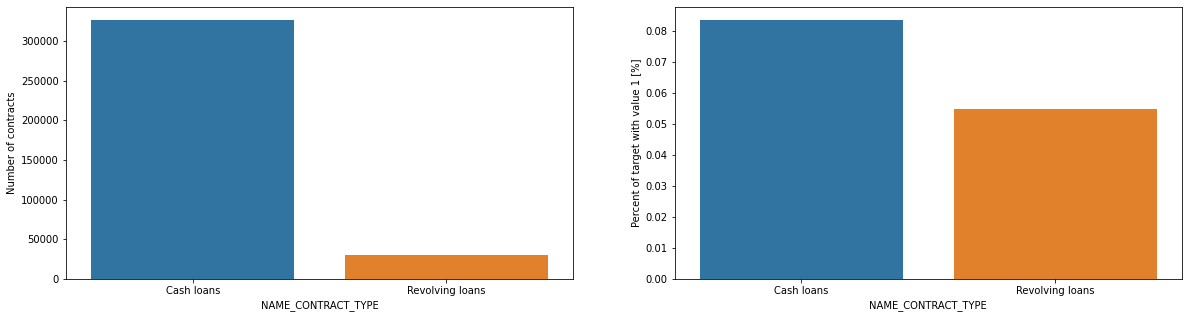

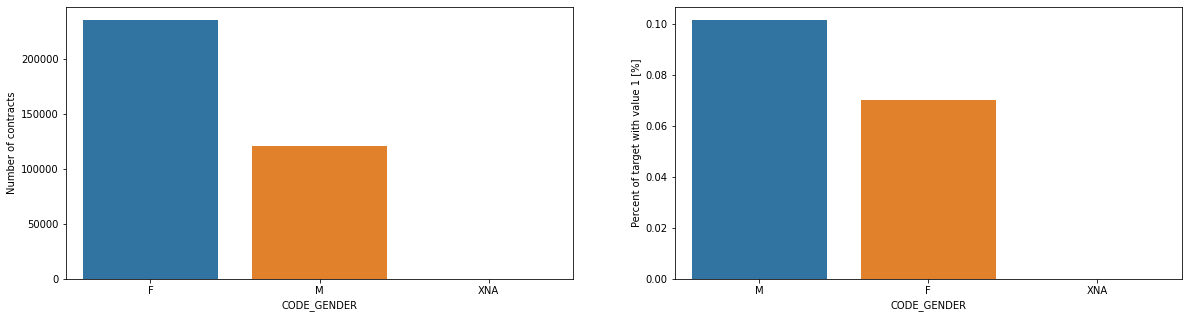

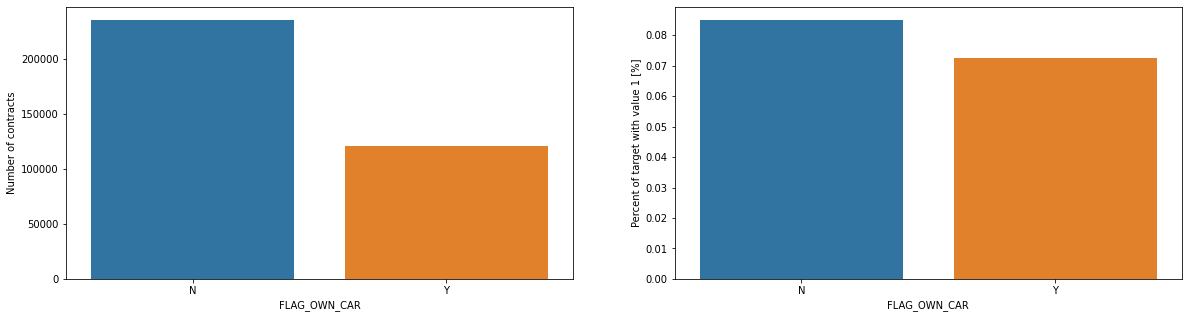

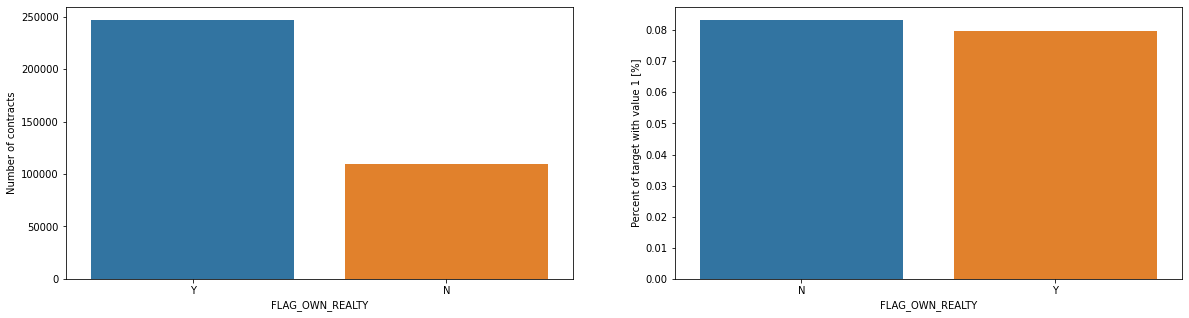

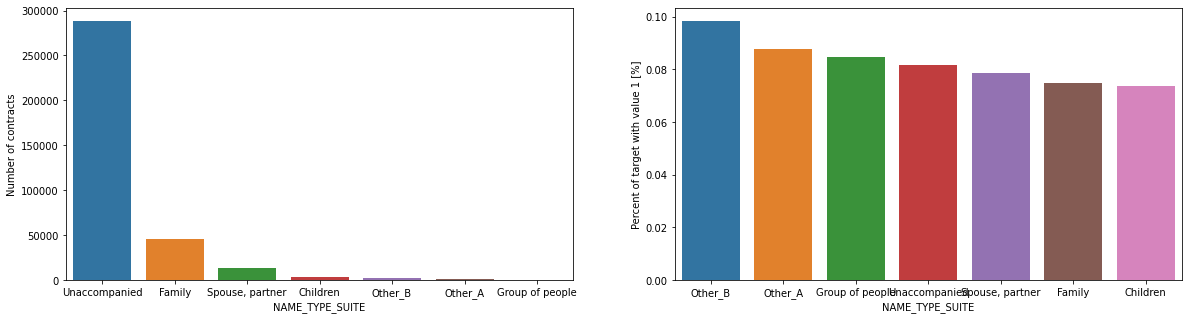

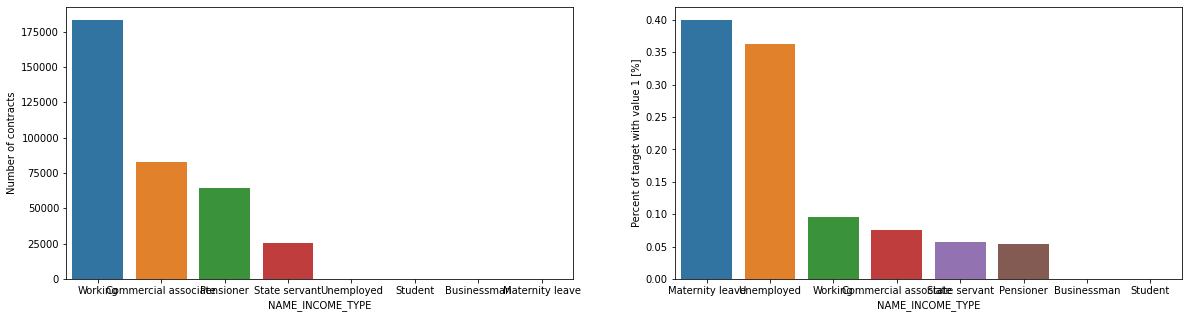

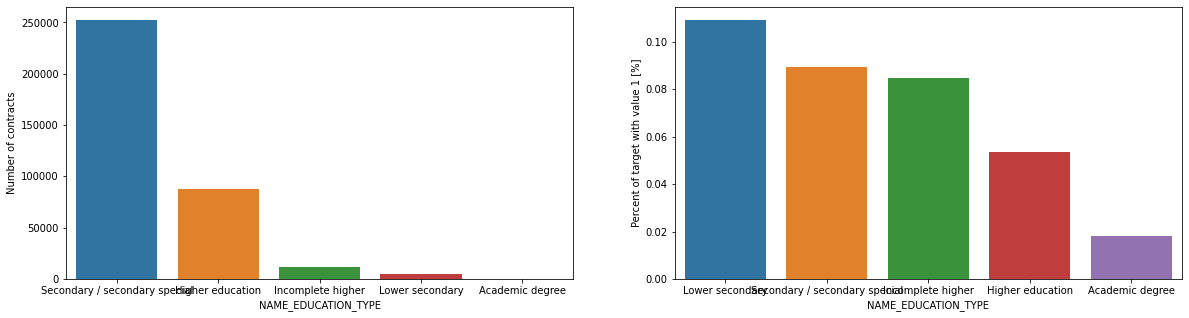

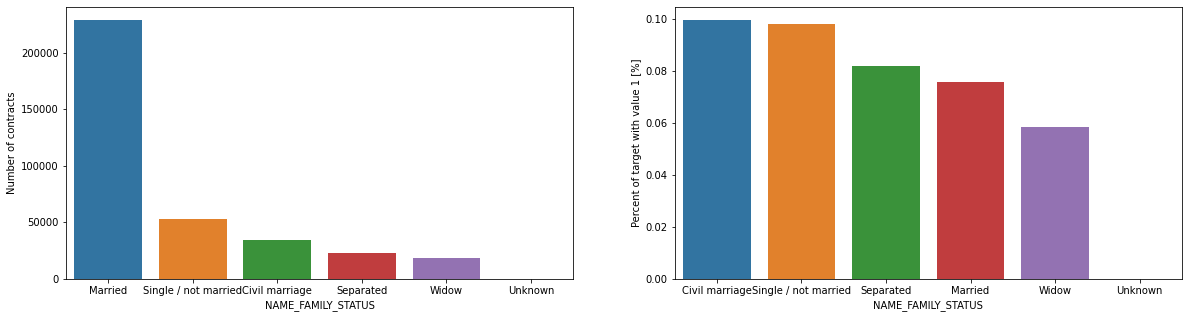

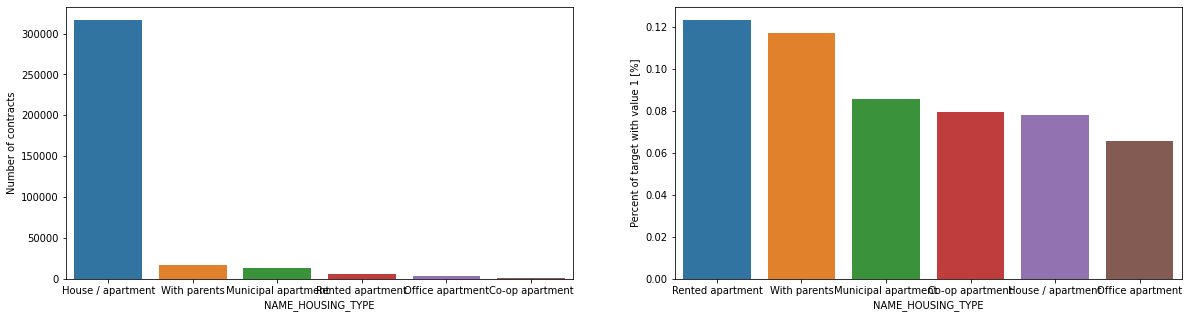

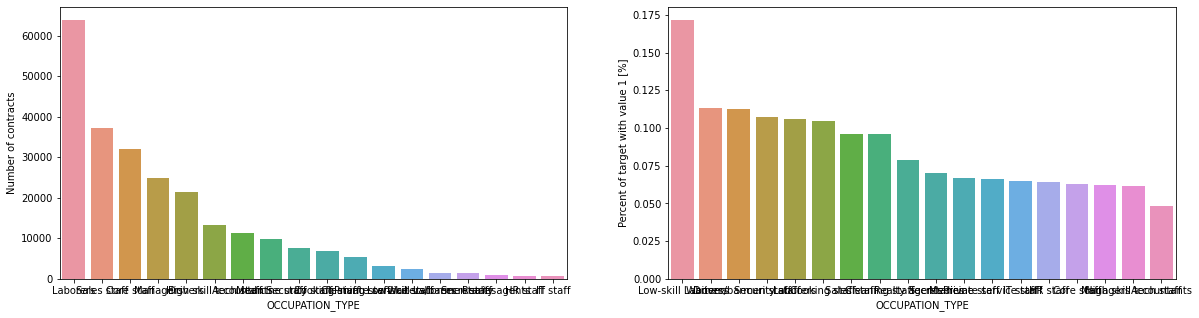

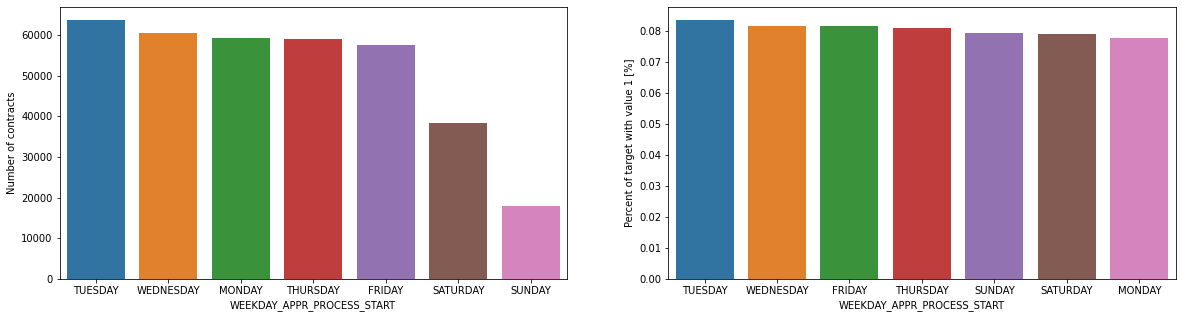

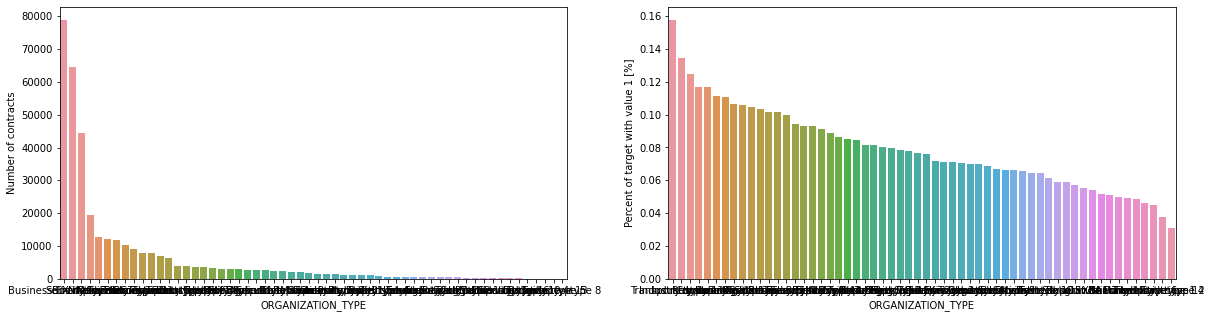

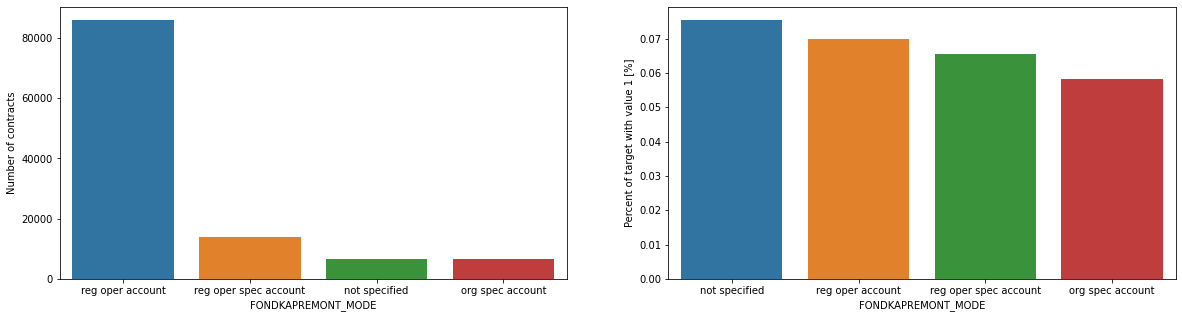

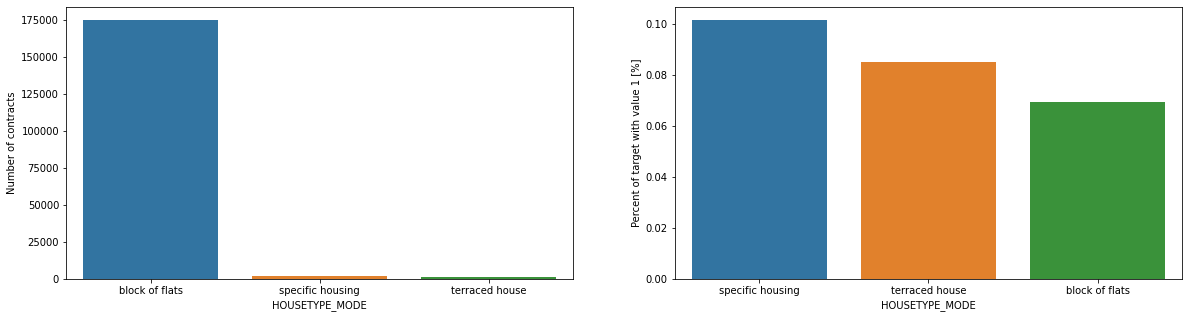

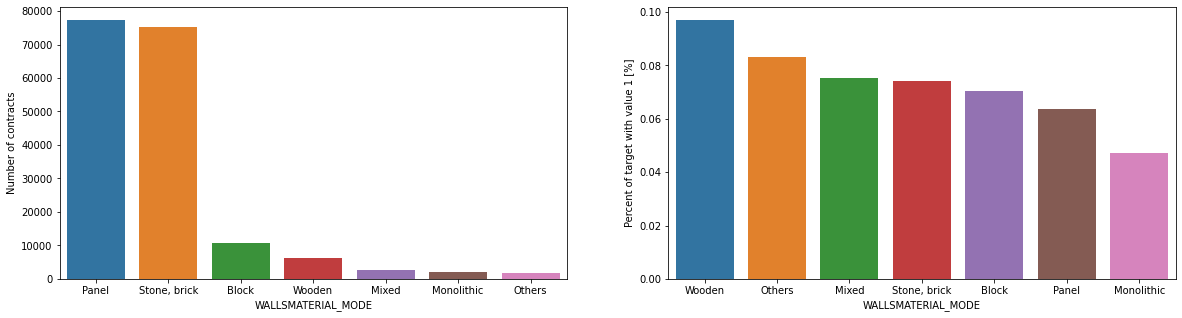

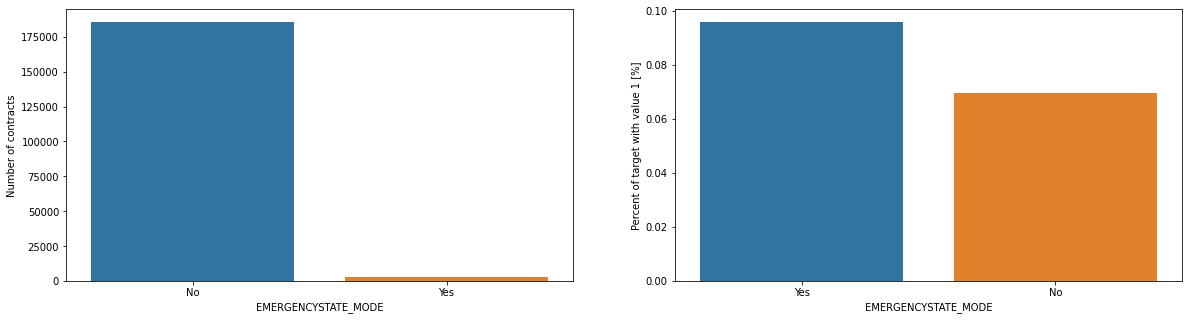

In [13]:
for i in column:
  plot_stats(i)

<Figure size 432x288 with 0 Axes>

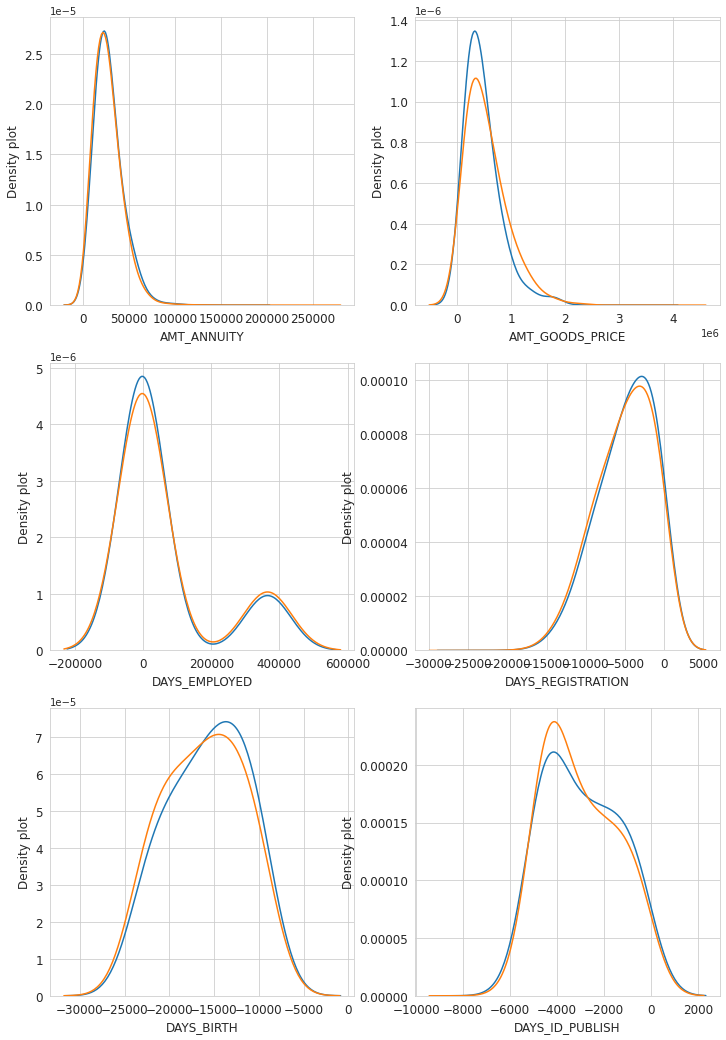

In [14]:
col_cont = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH']
plot_distribution_comp(col_cont,nrow=3)

## 2.4 Anomaly Detection

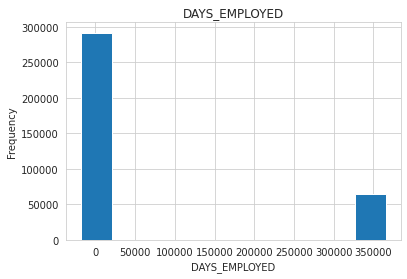

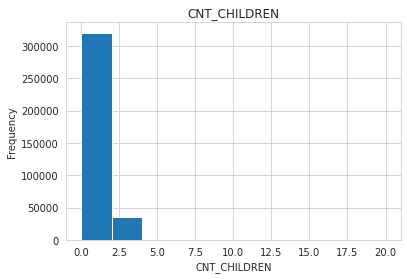

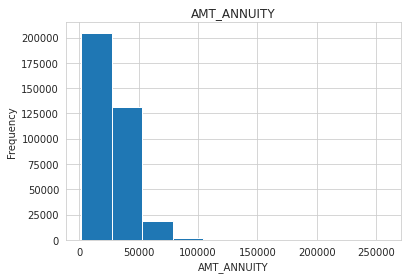

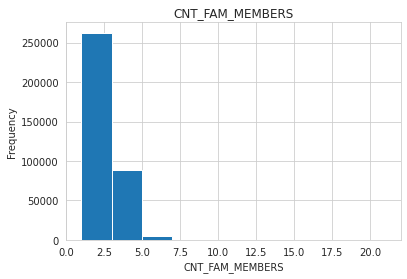

In [15]:
cols = ['DAYS_EMPLOYED', 'CNT_CHILDREN', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS']

for col in cols:
  train[col].plot.hist(title = col)
  plt.xlabel(col)
  plt.show()

## 2.5 Anomaly Handling

In [16]:
train = train[train['DAYS_EMPLOYED'] != 300000]
train = train[train['CNT_CHILDREN']<3]
train = train[train['AMT_ANNUITY']<130000]
train = train[train['CNT_FAM_MEMBERS']<7.5]

## 2.6 Correlations

In [17]:
correlations = train.corr()['TARGET'].sort_values()

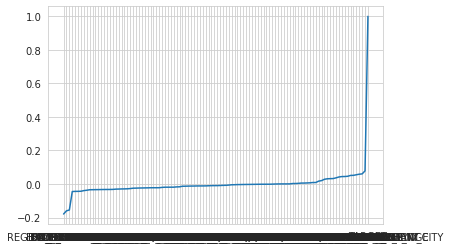

In [18]:
plt.plot(correlations)

In [19]:
sum(i < 0 for i in correlations)/len(correlations)

0.6981132075471698

Hence, Strong negative correlation

## 2.7 Data Cleaning and Feature Engineering

In [20]:
def get_age_dist(train):
  train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
  train['family_members_more7']= np.where(train['CNT_FAM_MEMBERS']>7,1,0)
  train['islowskilled_labour']= np.where(train['OCCUPATION_TYPE']=='Low-skill Laborers',1,0)
  train['is_Maternity_leave']= np.where(train['NAME_INCOME_TYPE'] =='Maternity leave' ,1,0)
  train['is_unemployed']= np.where(train['NAME_INCOME_TYPE'] =='Unemployed' ,1,0)

  train['cnt_childern_more6']= np.where(train['CNT_CHILDREN'] > 6,1,0)

  # Plot the distribution of ages in years
  plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
  plt.title('Age Distribution'); plt.xlabel('Age'); plt.ylabel('Count')

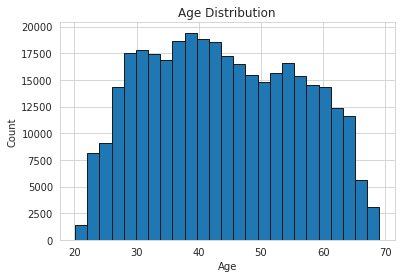

In [21]:
get_age_dist(train) # to visualize the age distribution

In [22]:
# Function to convert the age to categorical label
def get_age_label(days_birth):
    age_years = -days_birth / 365
    if age_years < 30:
      return 1
    elif age_years < 40:
      return 2
    elif age_years < 50: 
      return 3
    elif age_years < 60: 
      return 4
    elif age_years < 70: 
      return 5
    elif age_years > 70: 
      return 6
    else: 
      return 0

In [23]:
train = train[train['CODE_GENDER']!='XNA']
train['AGE_RANGE'] = train['DAYS_BIRTH'].apply(lambda x: get_age_label(x))
train['CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
train['DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['CREDIT_TO_GOODS_RATIO'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']
train['INCOME_TO_EMPLOYED_RATIO'] = train['AMT_INCOME_TOTAL'] / train['DAYS_EMPLOYED']
train['INCOME_TO_BIRTH_RATIO'] = train['AMT_INCOME_TOTAL'] / train['DAYS_BIRTH']
train['ID_TO_BIRTH_RATIO'] = train['DAYS_ID_PUBLISH'] / train['DAYS_BIRTH']
train['CAR_TO_BIRTH_RATIO'] = train['OWN_CAR_AGE'] / train['DAYS_BIRTH']
train['CAR_TO_EMPLOYED_RATIO'] = train['OWN_CAR_AGE'] / train['DAYS_EMPLOYED']
train['PHONE_TO_BIRTH_RATIO'] = train['DAYS_LAST_PHONE_CHANGE'] / train['DAYS_BIRTH']
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    train[feature_name] = eval('np.{}'.format(function_name))(
        train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
train['EXT_SOURCES_PROD'] = train['EXT_SOURCE_1'] * train['EXT_SOURCE_2'] * train['EXT_SOURCE_3']
train['CREDIT_LENGTH'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']


external_sources = train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
imputer = SimpleImputer(strategy = 'median')
external_sources = imputer.fit_transform(external_sources)
external_sources= pd.DataFrame(external_sources, columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH'])

external_sources['SK_ID_CURR'] = train['SK_ID_CURR'].tolist()
train = train.merge(external_sources, on = 'SK_ID_CURR', how = 'left')

In [24]:
# To find all the columns with low correlation

get_low_corr = []
col = train.select_dtypes(include=['float','int']).columns
for i in col:
  val = train['TARGET'].corr(train[i])
  if(val <= 0.02) and (val >= -0.025):
    get_low_corr.append(i)

get_low_corr.remove('SK_ID_CURR')

len(get_low_corr)

70

In [25]:
get_low_corr.extend(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'])

In [26]:
len(get_low_corr)

86

In [27]:
# Drop the unrequired columns

train.drop(get_low_corr,axis=1,inplace=True)

In [28]:
train.shape

(351182, 64)

## 2.8 Label Encoding

In [29]:
col = train.select_dtypes(include=['object']).columns
for i in col:
  if len(list(train[i].unique())) <= 2:
            LabelEncoder().fit_transform(train[i])
train = pd.get_dummies(train)

In [30]:
train = train.replace([np.inf, -np.inf], np.nan)

# 3. Model Development

In [31]:
temp = train[train['TARGET'].notnull()]
test = train[train['TARGET'].isnull()]
train = temp
X,y = train.drop(['TARGET'],axis=1),train['TARGET'].values

X.shape, y.shape, train.shape, test.shape

((303105, 63), (303105,), (303105, 64), (48077, 64))

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y, shuffle = True)

X_train.shape, X_test.shape

((242484, 63), (60621, 63))

In [33]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [34]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

## 3.1 LightGBM Classifier

In [35]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [36]:
n_HP_points_to_test = 100

In [37]:
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)

In [38]:
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [39]:
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855,'imbalanced':True}

## 3.2 Model Training

In [40]:
X_train.columns =  ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns =  ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

model = lgb.LGBMClassifier(**clf.get_params())
model.set_params(**opt_parameters)
model.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.763288
[200]	valid's auc: 0.766248
[300]	valid's auc: 0.766935
[400]	valid's auc: 0.76722
[500]	valid's auc: 0.767351
[600]	valid's auc: 0.767507
[700]	valid's auc: 0.76757
[800]	valid's auc: 0.767596
[900]	valid's auc: 0.767628
[1000]	valid's auc: 0.76765
[1100]	valid's auc: 0.76767
[1200]	valid's auc: 0.767693
[1300]	valid's auc: 0.767709
[1400]	valid's auc: 0.767723
[1500]	valid's auc: 0.767753
[1600]	valid's auc: 0.767766
[1700]	valid's auc: 0.767781
[1800]	valid's auc: 0.767792
[1900]	valid's auc: 0.7678
[2000]	valid's auc: 0.767812
[2100]	valid's auc: 0.767825
[2200]	valid's auc: 0.76784
[2300]	valid's auc: 0.767854
[2400]	valid's auc: 0.767866
[2500]	valid's auc: 0.767873
[2600]	valid's auc: 0.767886
[2700]	valid's auc: 0.767902
[2800]	valid's auc: 0.767916
[2900]	valid's auc: 0.767934
[3000]	valid's auc: 0.767949
[3100]	valid's auc: 0.767956
[3200]	valid's auc: 0.767965
[3300]	valid's auc: 0.7679

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9234,
               imbalanced=True, importance_type='split', learning_rate=0.1,
               max_depth=-1, metric='None', min_child_samples=399,
               min_child_weight=0.1, min_split_gain=0.0, n_estimators=5000,
               n_jobs=4, num_leaves=13, objective=None, random_state=314,
               reg_alpha=2, reg_lambda=5, silent=True, subsample=0.855,
               subsample_for_bin=200000, subsample_freq=0)

## 3.2 Model Evaluation

In [41]:
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

0.884268794423728

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9198957456986853

## Submission.csv Generation

In [43]:
del test['TARGET']

In [44]:
sub = model.predict(test)

In [54]:
ids = np.setdiff1d(submission_true['SK_ID_CURR'], test['SK_ID_CURR'])

In [74]:
sub = np.pad(sub, (0,len(ids)), 'constant')

In [46]:
submission_true = pd.read_csv('/content/datasets/application_test.csv')

In [75]:
submission = pd.DataFrame()
temp = test['SK_ID_CURR'].values
temp = temp.tolist()
temp.extend(ids)
submission['SK_ID_CURR'] = temp
submission['TARGET'] = sub

submission.to_csv('CREDIT_RISK_EDA.csv', index = False)